# Prototype-Based Recurrent Drift Detection

This notebook implements a prototype-based approach for detecting concept drift in data streams, including recurrent drifts. The method:

1. Divides the stream into windows
2. Generates prototype descriptions for each window
3. Compares all windows using a distance matrix
4. Clusters windows to identify concepts and detect drifts (including recurrent ones)

The distance-based comparison allows detecting recurrent drifts since distances are based on actual similarity rather than temporal proximity.

## 1. Imports

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from river import forest
from src.recurrence.full_window_storage import FullWindowStorage
from src.recurrence.methods import (
    cluster_windows,
    get_drift_from_clusters,
    median_mask,
    median_mask_2d,
    clustered_labels_accuracy,
    threshold_test,
    plot_threshold_analysis_results,
    create_prototypes_for_stream,
    prepare_dataset_from_generator,
    visualize_distance_matrix
)
from src.recurrence.visualisation import (
    plot_prototype_comparison,
    plot_cluster_timeline,
    plot_distance_to_all_windows,
    plot_window_detail
)

# Optional: For evaluation metrics
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score

%matplotlib inline

## 2. Prepare Dataset

In [101]:
# Configuration
size_of_box = 1000  # Window size

# Generate dataset using your dataset generator
from src.datasets import get_dataset
generator = get_dataset("rbf_drift")
X, y = generator.generate(size_of_box, size_of_box)

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Total samples: {len(X)}")
print(f"Number of windows: {len(X) // size_of_box}")

Dataset shape: X=(2000, 4), y=(2000,)
Total samples: 2000
Number of windows: 2


In [102]:
# Multiply the data 10 times if necessary

X_new = pd.DataFrame(
    np.vstack([
        np.tile(X.iloc[:1000].to_numpy(), (10, 1)),
        np.tile(X.iloc[1000:].to_numpy(), (10, 1)),
    ]),
    columns=X.columns
)

y_new = pd.Series(
    np.concatenate([
        np.tile(y.iloc[:1000].to_numpy(), 10),
        np.tile(y.iloc[1000:].to_numpy(), 10),
    ])
)

X = X_new
y = y_new


In [ ]:
# Generate dataset using your dataset generator
from src.datasets import get_dataset
generator = get_dataset("random_tree_multi_window")
X, y = generator.generate(num_windows=40, window_length=1000,
                 drift_positions=[10_000, 20_000, 30_000], drift_duration=1,)

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Total samples: {len(X)}")
print(f"Number of windows: {len(X) // size_of_box}")

Dataset shape: X=(40000, 6), y=(40000,)
Total samples: 40000
Number of windows: 40


In [104]:
# Prepare dataset in windowed format
window_size = 1000
dataset = prepare_dataset_from_generator(X, y, window_size=window_size)
print(f"Created {len(dataset)} windows")
print(f"Each window has {len(dataset[0][0])} samples")

Created 40 windows
Each window has 1000 samples


## 3. Run Prototype Creation and Window Storage

In [105]:
# Setup model and storage
model = forest.ARFClassifier()
storage = FullWindowStorage()

# Create prototypes for all windows
create_prototypes_for_stream(model, storage, dataset, verbose=True)

0/40
Anomaly detected. Window: 6 class: 0
Anomaly detected. Window: 8 class: 0
10/40
Anomaly detected. Window: 16 class: 1
20/40
Anomaly detected. Window: 22 class: 0
30/40

Stored 40 windows


## 4. Compute Distance Matrix

In [106]:
# Compute distance matrix between all windows
# Available measures: 'centroid_displacement', 'prototype_reassignment_impact', 
#                     'minimal_distance', 'mutual_information', 'rand_index', etc.
measure = 'centroid_displacement' 

matrix = storage.compute_distance_matrix(measure=measure, verbose=True)
print(f"Matrix shape: {matrix.shape}")

Computing 40x40 distance matrix using centroid_displacement...
  Progress: 0/40
  Progress: 10/40
  Progress: 20/40
  Progress: 30/40
Complete!
Matrix shape: (40, 40)


## 5. Visualize Distance Matrix

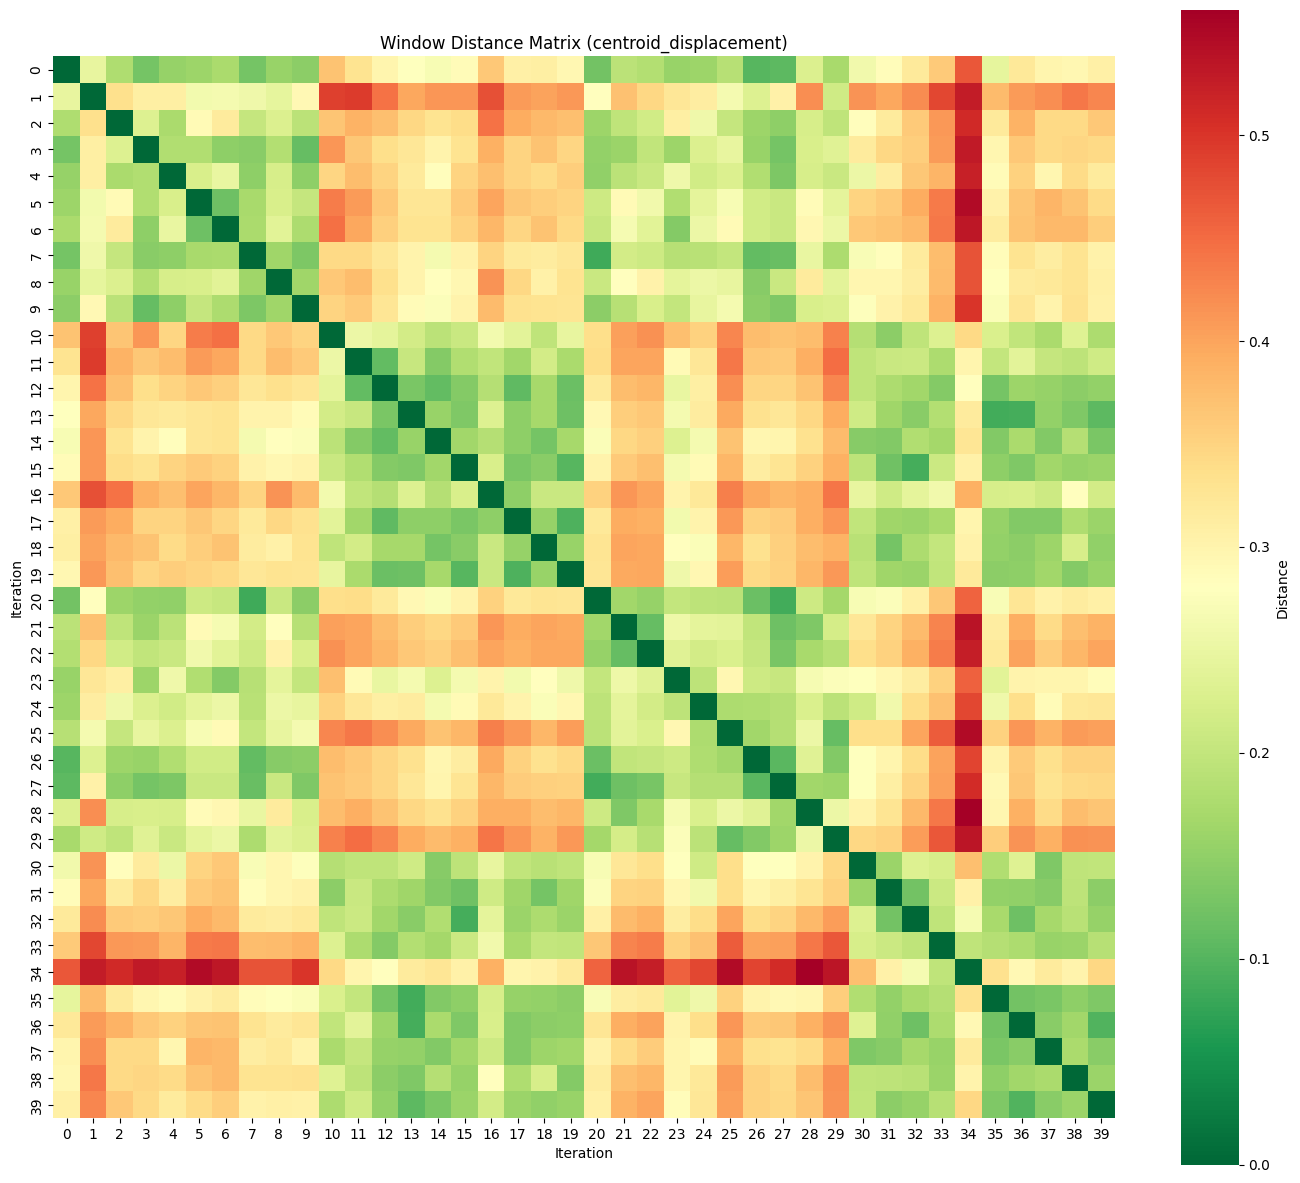

In [107]:
# Visualize the raw distance matrix
visualize_distance_matrix(matrix, title=f"Window Distance Matrix ({measure})")

## 6. Cluster Windows into Concepts

In [108]:
# Cluster windows to identify concepts
# median_mask_width: Apply median filter for noise reduction (use odd numbers, 1=no filtering)
# fix_outliers: Fill gaps between same cluster labels

labels = cluster_windows(matrix, fix_outliers=True, median_mask_width=1)
print("Cluster labels:", labels)
print("\nUnique clusters and their counts:")
unique, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique, counts):
    label_str = "Outlier" if label == -1 else f"Concept {label}"
    print(f"  {label_str}: {count} windows")

Cluster labels: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1]

Unique clusters and their counts:
  Concept 0: 20 windows
  Concept 1: 20 windows


In [109]:
# Detect drift locations from cluster transitions
drift_locations = get_drift_from_clusters(labels)
print(f"Detected {len(drift_locations)} drift points:")
print(drift_locations)

Detected 3 drift points:
[10, 20, 30]


## 7. Visualize Cluster Timeline

In [110]:
# Plot interactive cluster timeline showing concept changes over time
plot_cluster_timeline(labels, drift_locations=drift_locations, 
                     title="Concept Timeline with Detected Drifts")

## 8. Distance Matrix with Drift Markers

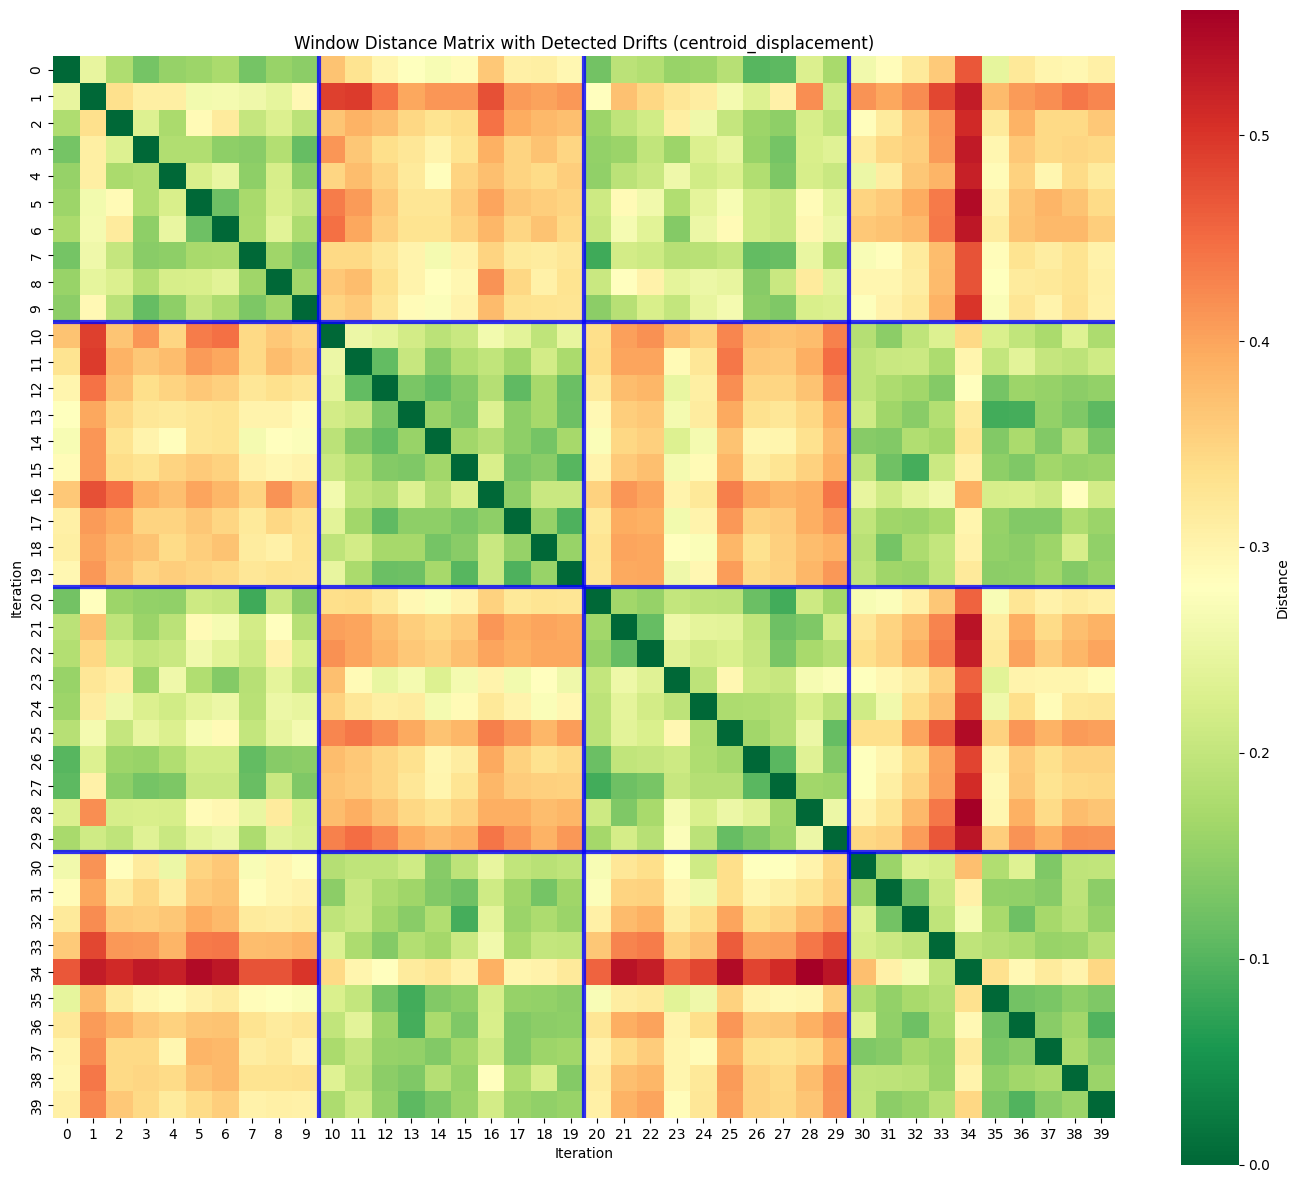

In [111]:
# Visualize distance matrix with detected drift locations marked
visualize_distance_matrix(matrix, drift_positions=drift_locations,
                         title=f"Window Distance Matrix with Detected Drifts ({measure})")

## 9. Effect of Median Filtering

### 9.1 Apply 3x3 Median Filter

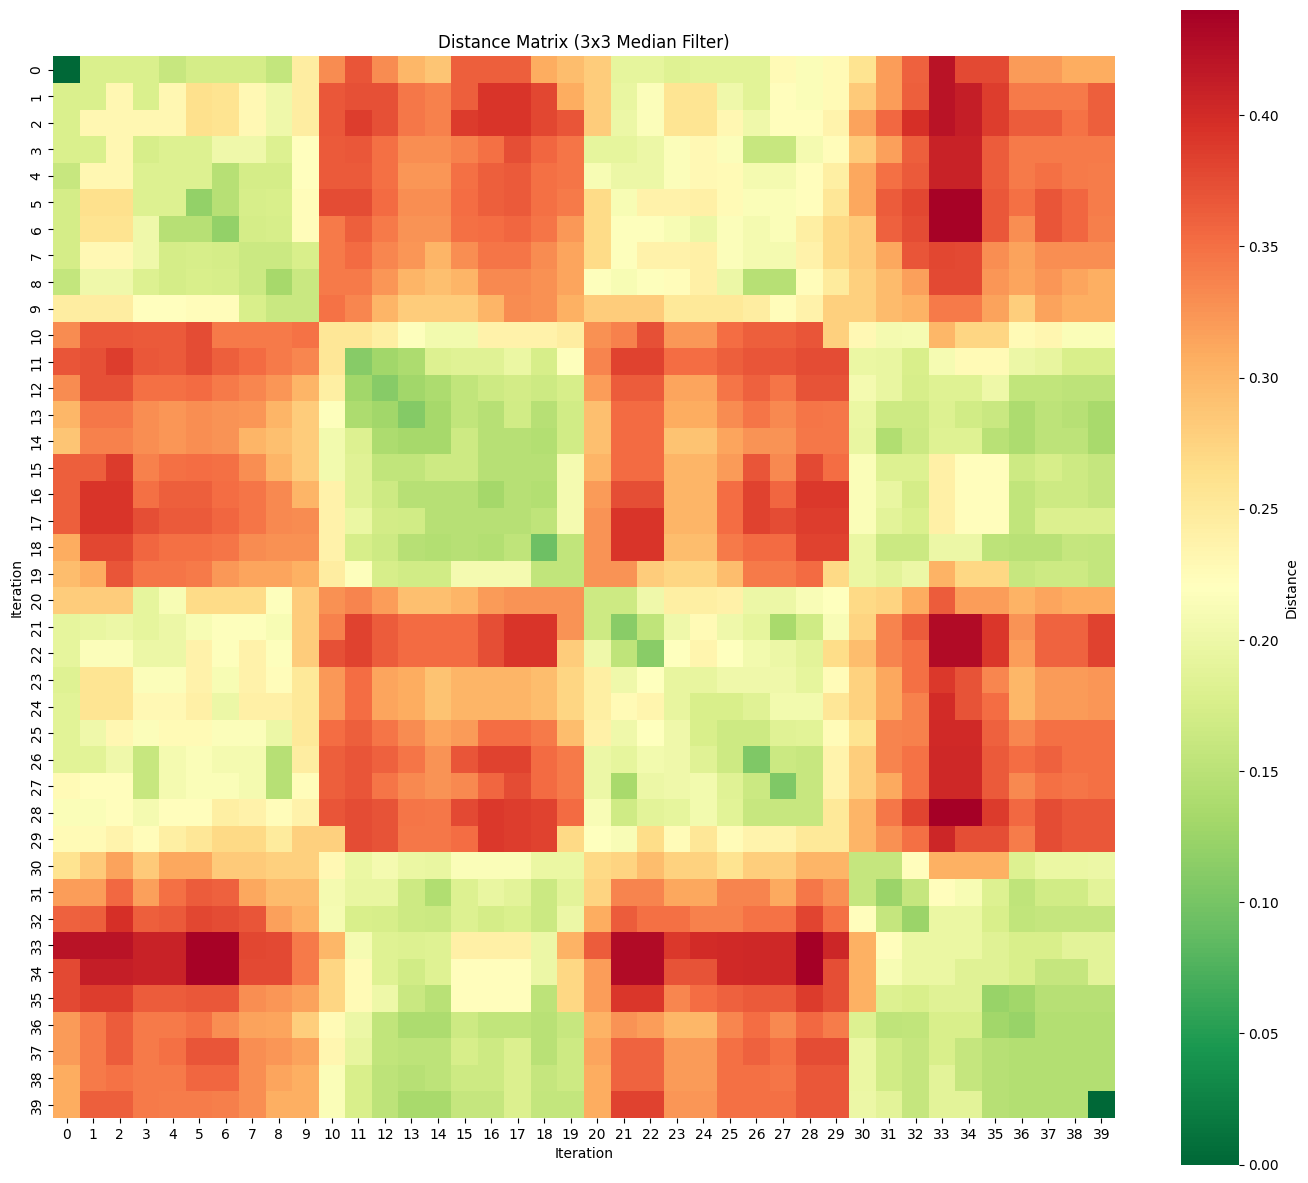

In [112]:
# Apply median filter to smooth the distance matrix
matrix_filtered = pd.DataFrame(median_mask_2d(matrix, ky=3, kx=3))
visualize_distance_matrix(matrix_filtered, title="Distance Matrix (3x3 Median Filter)")

In [113]:
# Cluster with median filtering
labels_filtered = cluster_windows(matrix, median_mask_width=3, fix_outliers=True)
drift_locations_filtered = get_drift_from_clusters(labels_filtered)

print("Filtered cluster labels:", labels_filtered)
print(f"\nDetected {len(drift_locations_filtered)} drift points:")
print(drift_locations_filtered)
print("\nUnique clusters and their counts:")
unique, counts = np.unique(labels_filtered, return_counts=True)
for label, count in zip(unique, counts):
    label_str = "Outlier" if label == -1 else f"Concept {label}"
    print(f"  {label_str}: {count} windows")

Filtered cluster labels: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1]

Detected 3 drift points:
[10, 20, 30]

Unique clusters and their counts:
  Concept 0: 20 windows
  Concept 1: 20 windows


In [114]:
# Plot filtered cluster timeline
plot_cluster_timeline(labels_filtered, drift_locations=drift_locations_filtered,
                     title="Concept Timeline (3x3 Median Filter)")

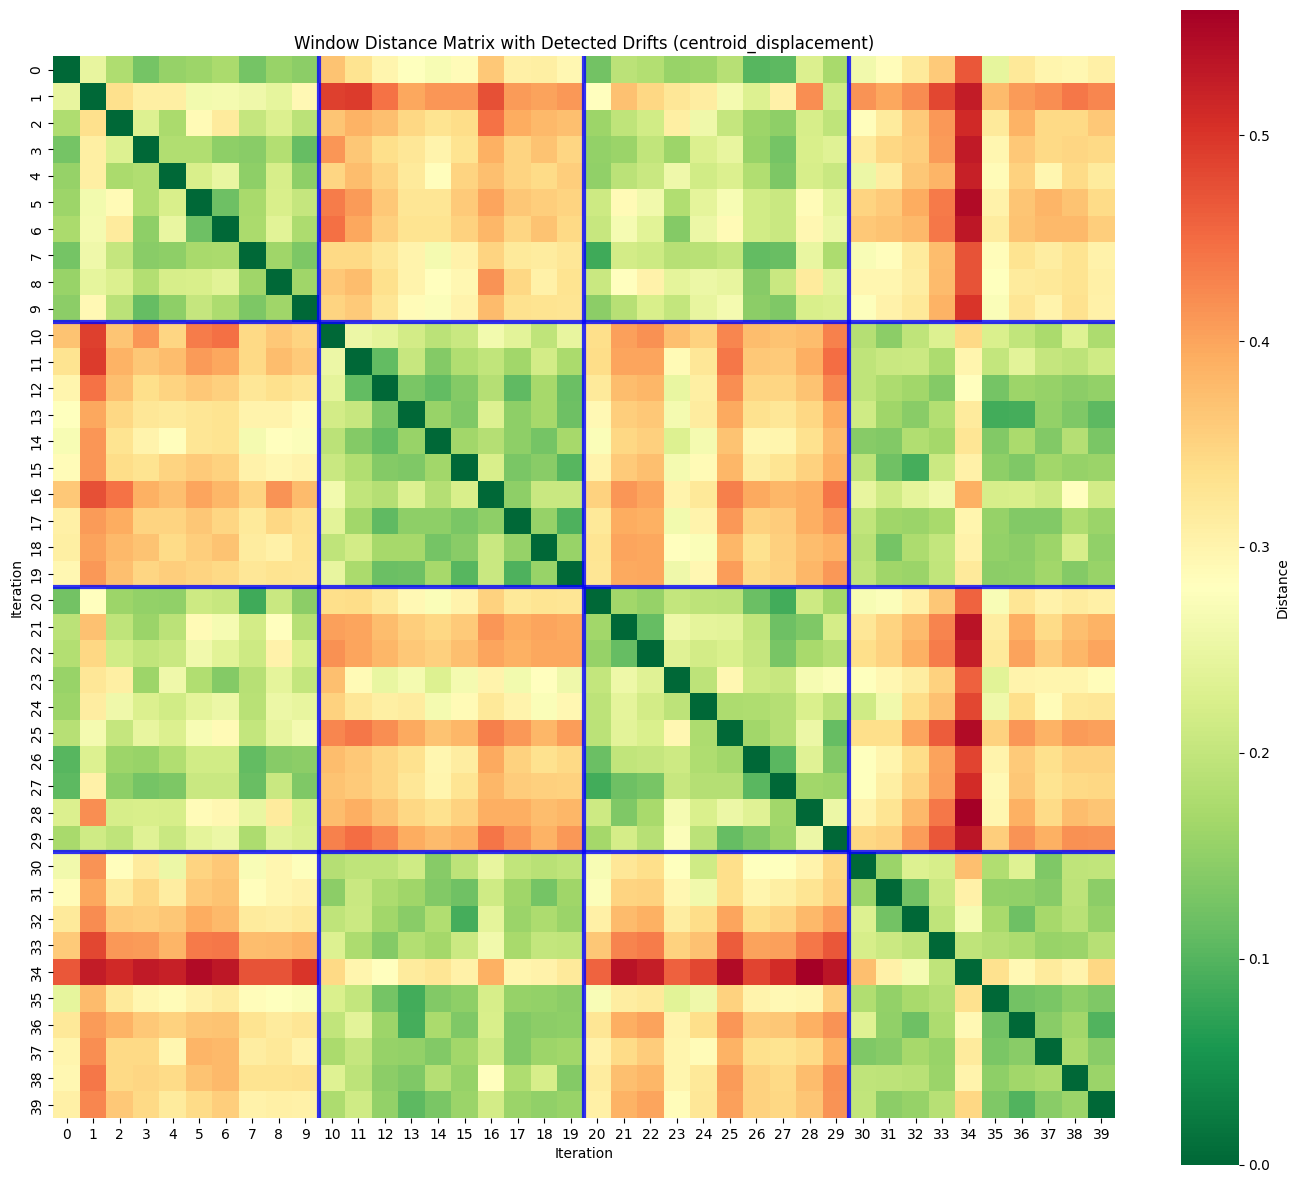

In [115]:
# Visualize distance matrix with detected drift locations marked
visualize_distance_matrix(matrix, drift_positions=drift_locations_filtered,
                         title=f"Window Distance Matrix with Detected Drifts ({measure})")

## 10. Local Analysis - Distance from Specific Window

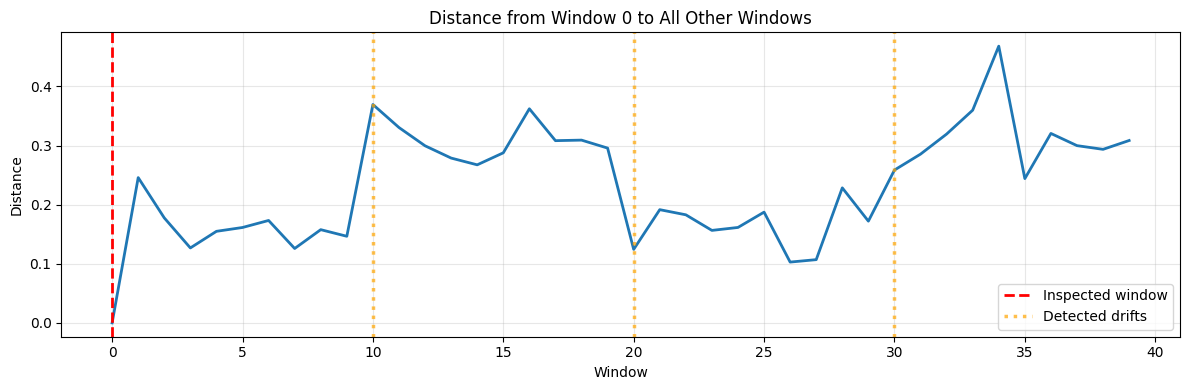

In [116]:
# Select a window to analyze
selected_window = 0  # Change this to analyze different windows

# Plot distance from selected window to all others
plot_distance_to_all_windows(storage, selected_window, 
                            drift_locations=drift_locations,
                            measure=measure, 
                            k_median=1)  # Increase for smoothing

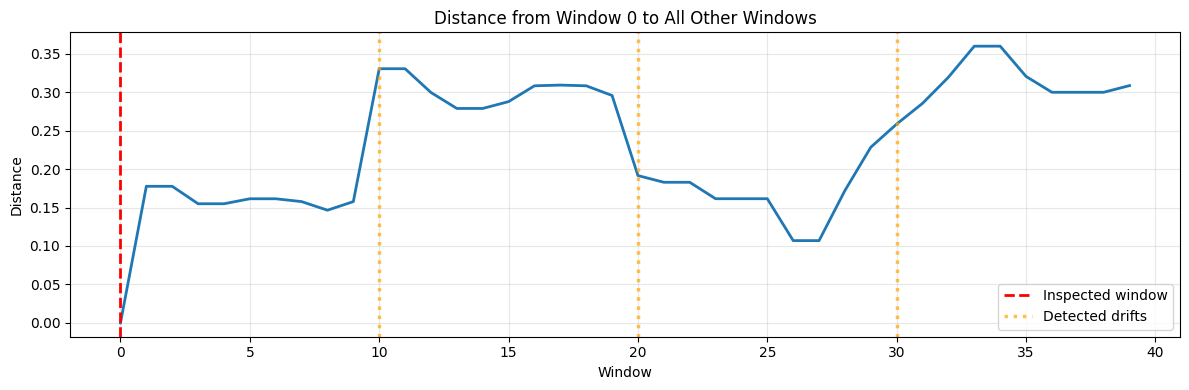

In [117]:
# With median filtering for smoother visualization
plot_distance_to_all_windows(storage, selected_window,
                            drift_locations=drift_locations,
                            measure=measure,
                            k_median=3)

## 11. Window Detail Analysis

In [118]:
# Detailed analysis of a specific window's prototypes
plot_window_detail(storage, selected_window)


Window 0 - Detailed Analysis

Total samples: 1000
Total prototypes: 23
Classes: [0, 1]


------------------------------------------------------------
Class 0
------------------------------------------------------------
Number of prototypes: 7
219 samples have their closest prototype from class 0

  • Prototype 1: Closest to 58 samples (Class 0: 47, Class 1: 11)
  • Prototype 2: Closest to 53 samples (Class 0: 33, Class 1: 20)
  • Prototype 3: Closest to 14 samples (Class 0: 8, Class 1: 6)
  • Prototype 4: Closest to 25 samples (Class 0: 24, Class 1: 1)
  • Prototype 5: Closest to 25 samples (Class 0: 24, Class 1: 1)
  • Prototype 6: Closest to 36 samples (Class 0: 26, Class 1: 10)
  • Prototype 7: Closest to 8 samples (Class 0: 3, Class 1: 5)

  Feature Statistics Across Prototypes:
Feature     Mean      Std      Min      Max
     x0 0.469158 0.337572 0.000000 1.000000
     x1 0.303321 0.127605 0.143459 0.575714
     x2 0.503320 0.082754 0.359869 0.614522
     x3 0.532915 0.186040 0.2

## 12. Compare Prototypes Across Windows

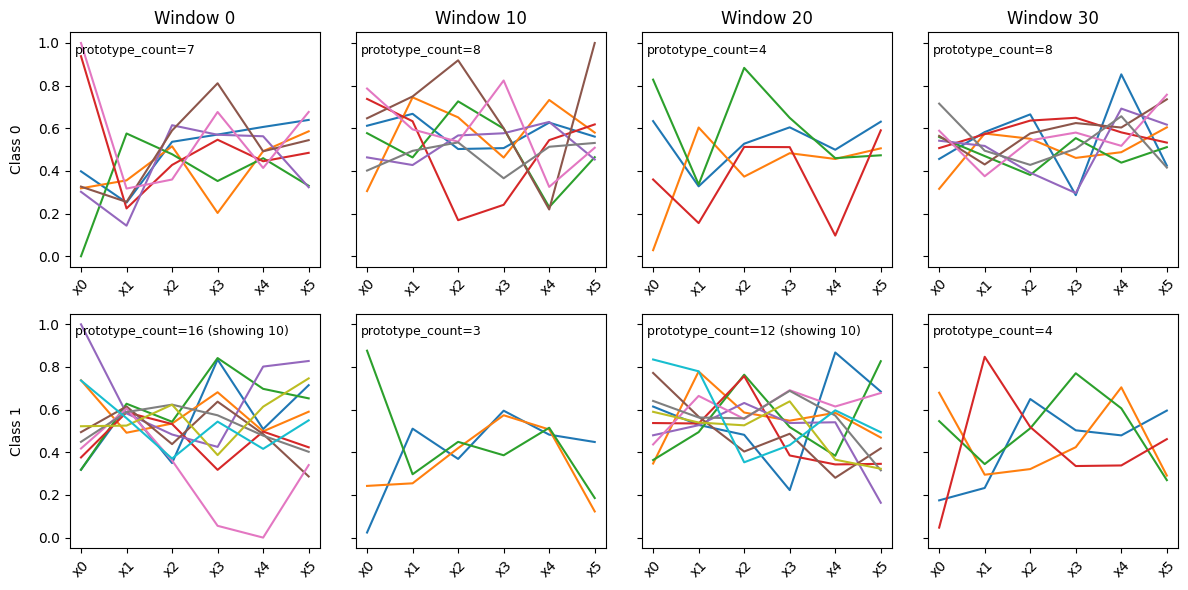

In [126]:
# Compare prototypes from different windows/concepts
# Select windows that represent different concepts or before/after drifts
windows_to_compare = [0] + drift_locations  # Adjust based on your data

plot_prototype_comparison(storage, windows_to_compare, max_prototypes=10)

## 13. Evaluation (Optional - if ground truth is available)

In [ ]:
# Define ground truth concept labels if available
# Example: This is dataset-specific and should match your actual drift points
def get_true_concept(window_nr):
    """Define ground truth concept for each window.
    
    Modify this function based on your dataset's actual drift points.
    """
    if window_nr < 10:
        return 0
    elif window_nr < 20:
        return 1
    elif window_nr < 30:
        return 0
    else:
        return 1

# Create ground truth array
true_concept_list = np.array([get_true_concept(i) for i in range(len(labels))])
print("Ground truth concepts:", true_concept_list)

Ground truth concepts: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1]


### 13.1 Clustering Quality Metrics

In [121]:
# Evaluate clustering quality
print("Clustering Evaluation Metrics:")
print(f"Adjusted Rand Score: {adjusted_rand_score(true_concept_list, labels):.4f}")
print(f"Adjusted Mutual Info Score: {adjusted_mutual_info_score(true_concept_list, labels):.4f}")
print(f"Fowlkes-Mallows Score: {fowlkes_mallows_score(true_concept_list, labels):.4f}")
print(f"Custom Accuracy (with outliers): {clustered_labels_accuracy(labels, true_concept_list, outliers_included=True):.4f}")
print(f"Custom Accuracy (without outliers): {clustered_labels_accuracy(labels, true_concept_list, outliers_included=False):.4f}")

Clustering Evaluation Metrics:
Adjusted Rand Score: 1.0000
Adjusted Mutual Info Score: 1.0000
Fowlkes-Mallows Score: 1.0000
Custom Accuracy (with outliers): 1.0000
Custom Accuracy (without outliers): 1.0000


### 13.2 Threshold Analysis

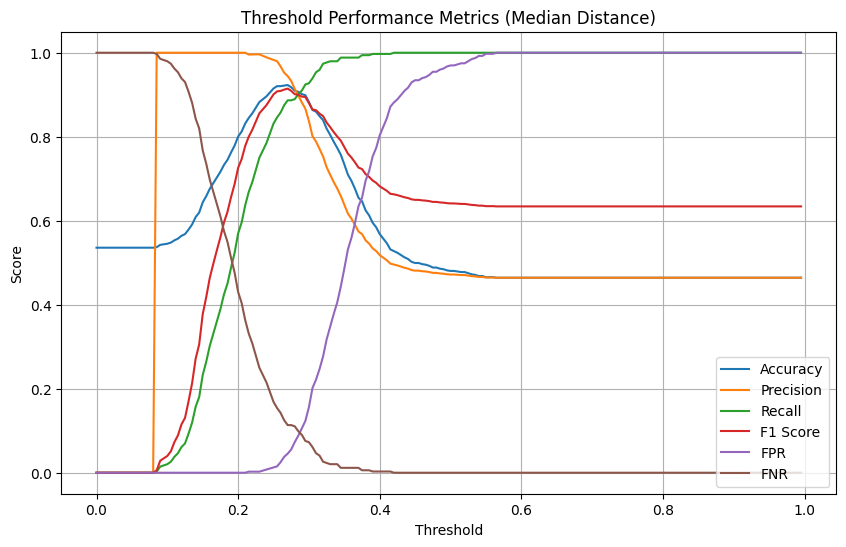

Best Threshold by F1:
{'threshold': 0.27, 'accuracy': 0.9230769230769231, 'precision': 0.9442724458204335, 'recall': 0.8866279069767442, 'fpr': 0.04534005037783375, 'fnr': 0.11337209302325581, 'f1': 0.9145427286356821}


In [122]:
# Test different threshold values for window similarity classification
# This analyzes how well different thresholds separate 'similar' vs 'different' concepts
results_unprocessed = threshold_test(matrix, true_concept_list, median_mask_dimensions=(1, 1))
plot_threshold_analysis_results(results_unprocessed)

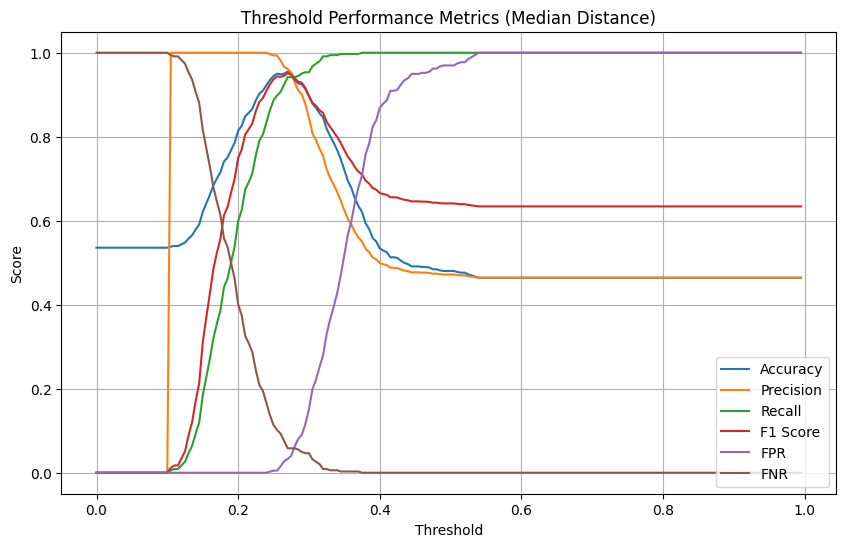

Best Threshold by F1:
{'threshold': 0.27, 'accuracy': 0.9554655870445344, 'precision': 0.9614243323442137, 'recall': 0.9418604651162791, 'fpr': 0.0327455919395466, 'fnr': 0.05813953488372093, 'f1': 0.9515418502202644}


In [123]:
# Test with median filtering
results_filtered = threshold_test(matrix, true_concept_list, median_mask_dimensions=(1, 3))
plot_threshold_analysis_results(results_filtered)

## 15. Summary and Export Results

In [124]:
# Summary of results
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Total windows processed: {len(storage.get_all_iterations())}")
print(f"Distance measure used: {measure}")
print(f"Number of concepts identified: {len(set(labels)) - (1 if -1 in labels else 0)}")
print(f"Number of outlier windows: {sum(labels == -1)}")
print(f"Detected drift points: {drift_locations}")
print(f"Total drifts detected: {len(drift_locations)}")
print("="*60)


SUMMARY
Total windows processed: 40
Distance measure used: centroid_displacement
Number of concepts identified: 2
Number of outlier windows: 0
Detected drift points: [10, 20, 30]
Total drifts detected: 3


In [125]:
# Export results to CSV
results_df = pd.DataFrame({
    'window': range(len(labels)),
    'cluster_label': labels,
    'is_drift': [i in drift_locations for i in range(len(labels))]
})

# Optionally add ground truth if available
if 'true_concept_list' in locals():
    results_df['true_concept'] = true_concept_list

print("\nResults DataFrame:")
display(results_df.head(20))

# Uncomment to save
# results_df.to_csv('drift_detection_results.csv', index=False)
# print("Results saved to drift_detection_results.csv")


Results DataFrame:


,window,cluster_label,is_drift,true_concept
0,0,0,False,0
1,1,0,False,0
2,2,0,False,0
3,3,0,False,0
4,4,0,False,0
5,5,0,False,0
6,6,0,False,0
7,7,0,False,0
8,8,0,False,0
9,9,0,False,0
